In [1]:
import matplotlib.pyplot as plt
from matplotlib import rc
# rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20

plt.rcParams['xtick.major.size'] = 18
plt.rcParams['ytick.major.size'] = 18
plt.rc('legend', fontsize=20)
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path



# power_mode="peak"
power_mode="mean"

In [2]:
def plot_variorum(path):
    f, ax = plt.subplots(4,2, figsize=(20,16), sharex=True)
    ax = ax.flatten()
    df = pd.read_csv(path)
    cols = df.columns[3:]
    print(cols)

    for idx, col in enumerate(cols):
        
        ax[idx].plot(df[col].values)
        ax[idx].set_ylabel(col)

    f.suptitle(path)

TIME_PER_SAMPLE=.05 # this corresponds to milliseconds, sampling interval for variorum

def convert_var_monitor_path_to_timing_path(path):
    mode = path.parent.name.split("_")[-1]
    model = path.parent.name.split("_")[0]
    timing_path = path.parent.parent / Path(f"{model}_timing_{mode}.npy") 
    return timing_path

def parse_var_monitor_output(path, power_mode="peak"):
    try:
        # import pdb
        # pdb.set_trace()
        path = Path(path)

        mode = path.parent.name.split("_")[-1]
        model = path.parent.name.split("_")[0]
        timing_path = convert_var_monitor_path_to_timing_path(path)
        timing_data = np.load(timing_path)
        N, mean_time_crit, std_time_crit = timing_data

        df = pd.read_csv(path)


         
        gpu_power = None
        cpu_power = None 
        print(f"using {power_mode} for power estimate.")
        if mode == "encode" and power_mode == "peak":
            gpu_power = df['GPU_0 Power (W)'].values.max()
            cpu_power = df[['Socket_0 Power (W)', 'Socket_1 Power (W)']].max().sum()
        elif mode=="encode" and power_mode == "mean":
            gpu_power = df['GPU_0 Power (W)'].values.mean()
            cpu_power = df[['Socket_0 Power (W)', 'Socket_1 Power (W)']].mean().sum()
        elif mode == "test" and power_mode == "mean":
            # trunc_sum_path = path.with_name(f"{path.stem}-trunc-sum.dat")
            # print(f"trunc_sum_path: {trunc_sum_path}")
            df = pd.read_csv(path, index_col=0)
            # assert "trunc-sum" in path.name
            gpu_power = df['GPU_0 Power (W)']['mean']
            cpu_power = df[['Socket_0 Power (W)', 'Socket_1 Power (W)']].loc['mean'].sum() 
        else:
            raise NotImplementedError

        # import pdb
        # pdb.set_trace() 
        cpu_energy = cpu_power * mean_time_crit
        gpu_energy = gpu_power * mean_time_crit

        # print(path, "direct" in path.name)
        if "direct" in path.parent.name and mode == "encode":
            gpu_energy = 0

        result_dict = {
                        "path": path, "model": model, "mode": mode,
                        "cpu_power": cpu_power, "gpu_power": gpu_power,
                        "mean_time_crit": mean_time_crit, "std_time_crit": std_time_crit, 
                        # "total_time": total_time, "mean_time": total_time/N,
                        # "mean_time_cpu": mean_time - mean_time_crit,
                        "cpu_energy": cpu_energy,
                        "gpu_energy": gpu_energy
                       }
        
        return pd.DataFrame(result_dict, index=[0])

    except Exception as e:
        print(e)
        return

def collect_energy_metrics(path_list, power_mode="peak", verbose=False):

    assert power_mode in ["peak", "mean", "trunc-sum"]

    result_list = []
    for p in path_list:
        result_list.append(parse_var_monitor_output(p, power_mode=power_mode))
        if verbose:
            print(p)
            plot_variorum(p)

    df = pd.concat([x for x in result_list if x is not None])
    df = df.reset_index(drop=True)
    return df

using mean for power estimate.
/g/g13/jones289/workspace/hd-cuda-master/hdpy/profile_1720235294/hdbind-directecfp-1k-1_variorum_encode/lassen405.var_monitor.dat
Index(['Socket_0 Power (W)', 'Mem_0 Power (W)', 'GPU_0 Power (W)',
       'GPU_1 Power (W)', 'Socket_1 Power (W)', 'Mem_1 Power (W)',
       'GPU_2 Power (W)', 'GPU_3 Power (W)'],
      dtype='object')
using mean for power estimate.
/g/g13/jones289/workspace/hd-cuda-master/hdpy/profile_1720235294/hdbind-molformer-decfp-combo-1k_variorum_encode/lassen405.var_monitor.dat
Index(['Socket_0 Power (W)', 'Mem_0 Power (W)', 'GPU_0 Power (W)',
       'GPU_1 Power (W)', 'Socket_1 Power (W)', 'Mem_1 Power (W)',
       'GPU_2 Power (W)', 'GPU_3 Power (W)'],
      dtype='object')
using mean for power estimate.
/g/g13/jones289/workspace/hd-cuda-master/hdpy/profile_1720235294/hdbind-rp-molformer-1k_variorum_encode/lassen405.var_monitor.dat
Index(['Socket_0 Power (W)', 'Mem_0 Power (W)', 'GPU_0 Power (W)',
       'GPU_1 Power (W)', 'Socket_1 P

,path,model,mode,cpu_power,gpu_power,mean_time_crit,std_time_crit,cpu_energy,gpu_energy
0,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-directecfp-1k-1,encode,158.299851,34.422957,3.622643e-04,8.163907e-08,0.057346,0.000000
1,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-molformer-decfp-combo-1k,encode,157.818036,47.704247,5.207949e-04,1.761928e-07,0.082191,0.024844
2,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-rp-molformer-1k,encode,154.015957,43.747952,1.516202e-07,7.264579e-10,0.000023,0.000007
3,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,mlp-large-1024-1,encode,159.234715,34.368890,3.636456e-04,7.313384e-08,0.057905,0.012498
4,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,mlp-small-1024-1,encode,161.075094,34.313010,3.636272e-04,4.252577e-08,0.058571,0.012477
0,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-directecfp-1k-1,test,158.289948,49.298218,1.222425e-07,1.620050e-08,0.000019,0.000006
1,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-molformer-decfp-combo-1k,test,158.032787,49.725410,1.120625e-07,2.035309e-08,0.000018,0.000006
2,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-rp-molformer-1k,test,157.740541,50.017730,9.921392e-08,7.009256e-09,0.000016,0.000005
3,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,mlp-large-1024-1,test,158.027933,62.386369,1.471285e-07,7.048933e-09,0.000023,0.000009
4,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,mlp-small-1024-1,test,159.659341,57.034451,4.025928e-08,5.996733e-09,0.000006,0.000002


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


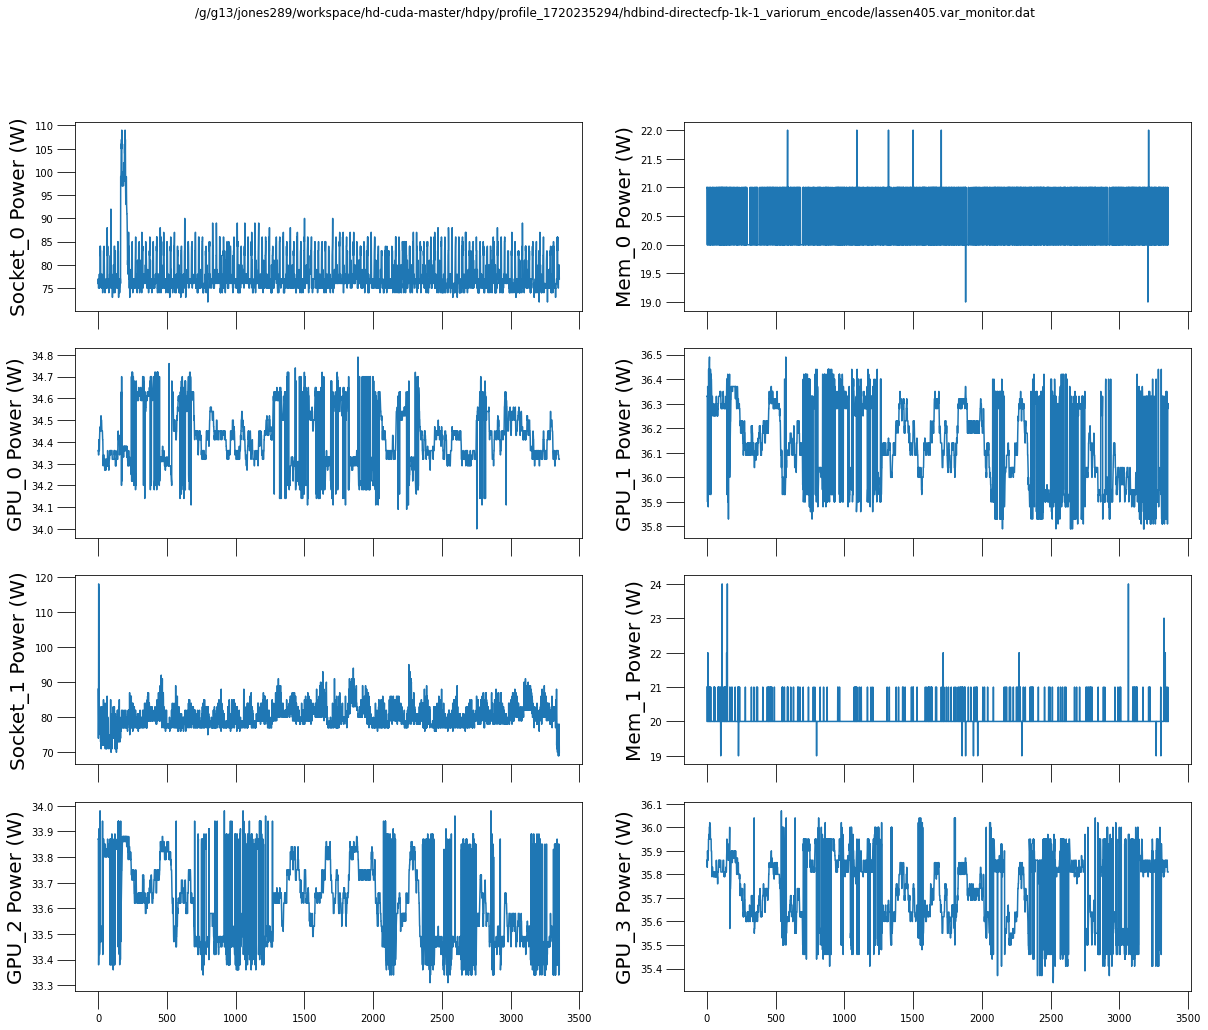

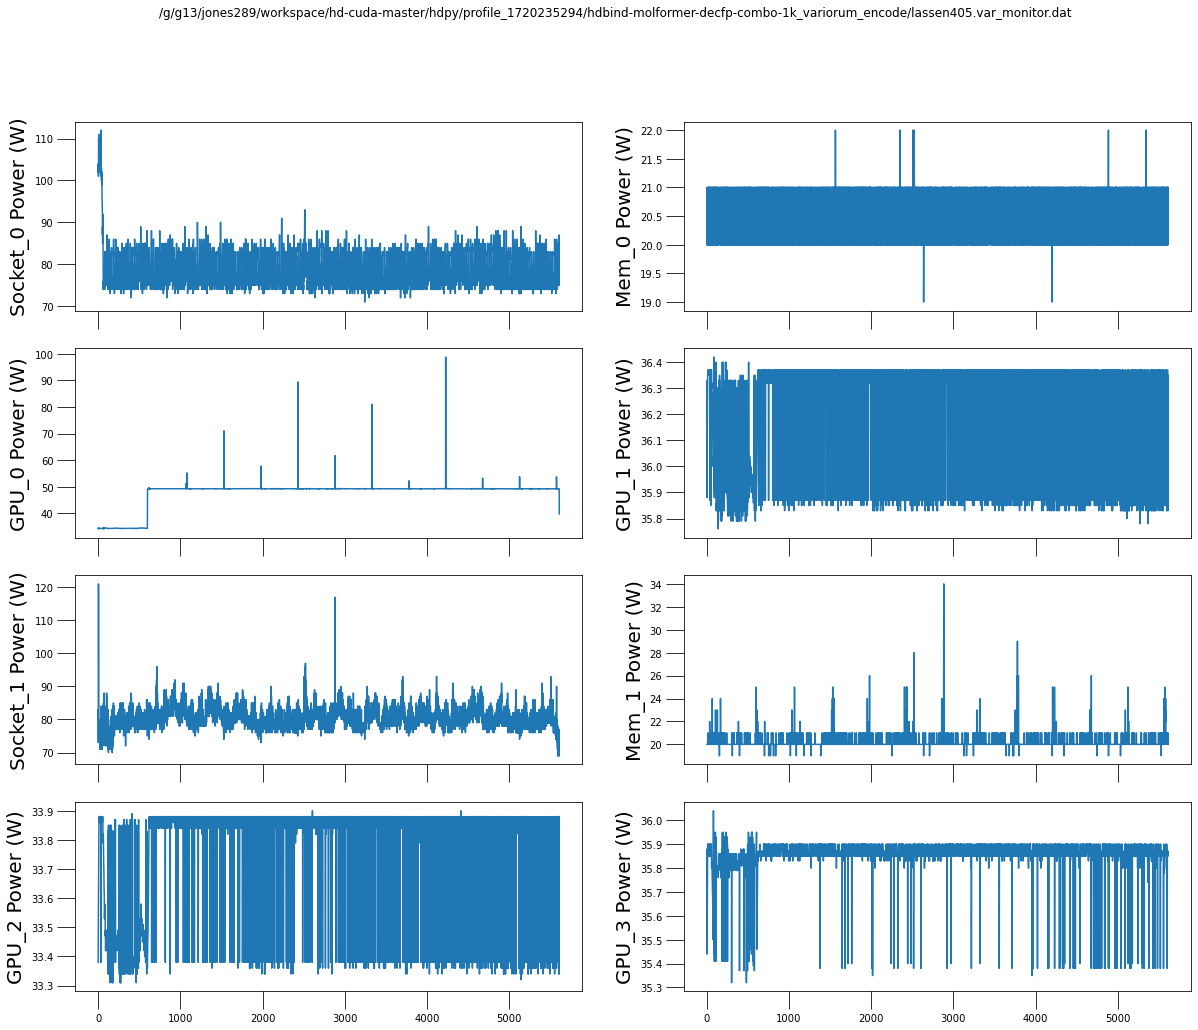

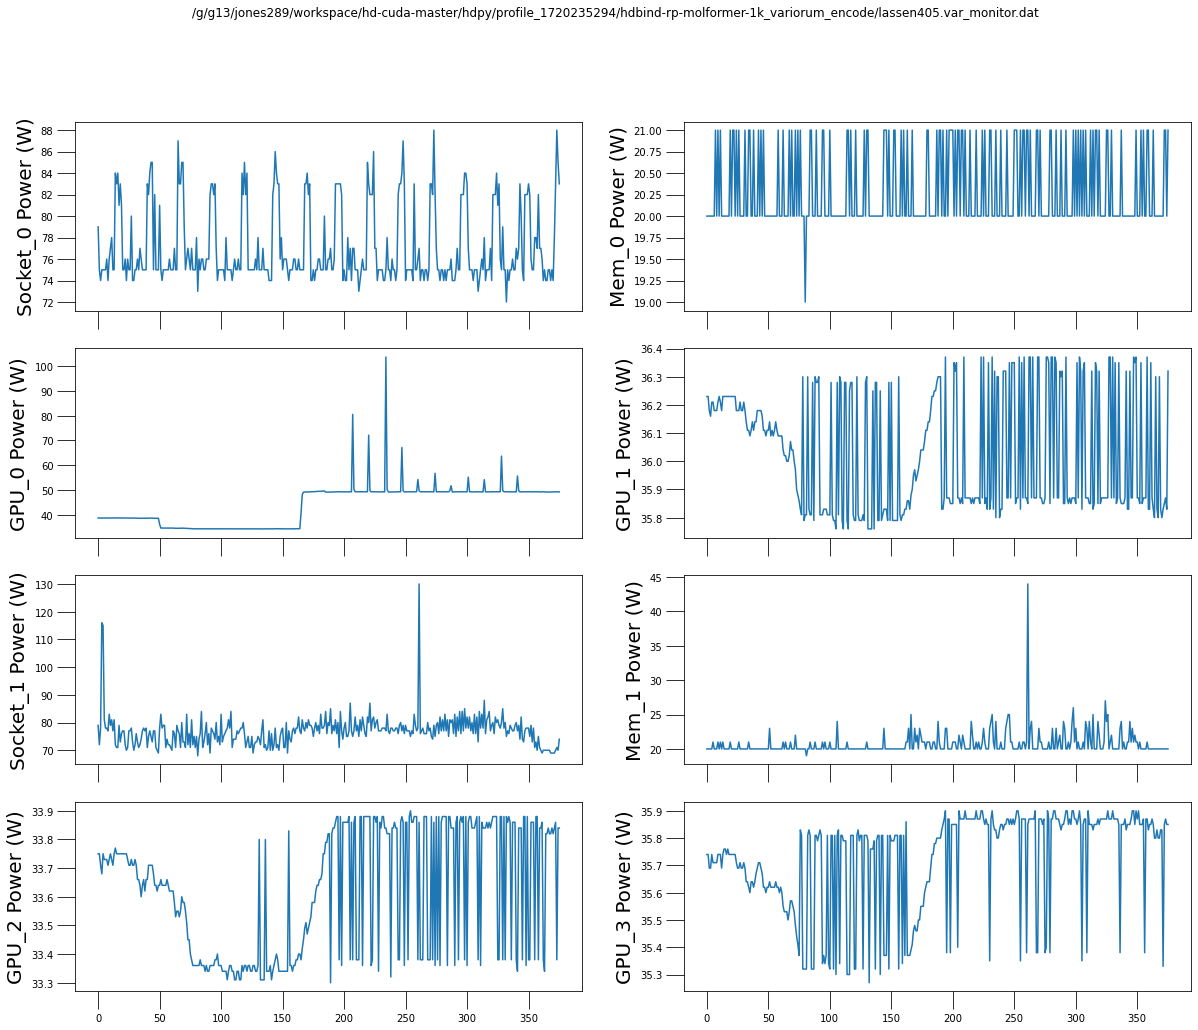

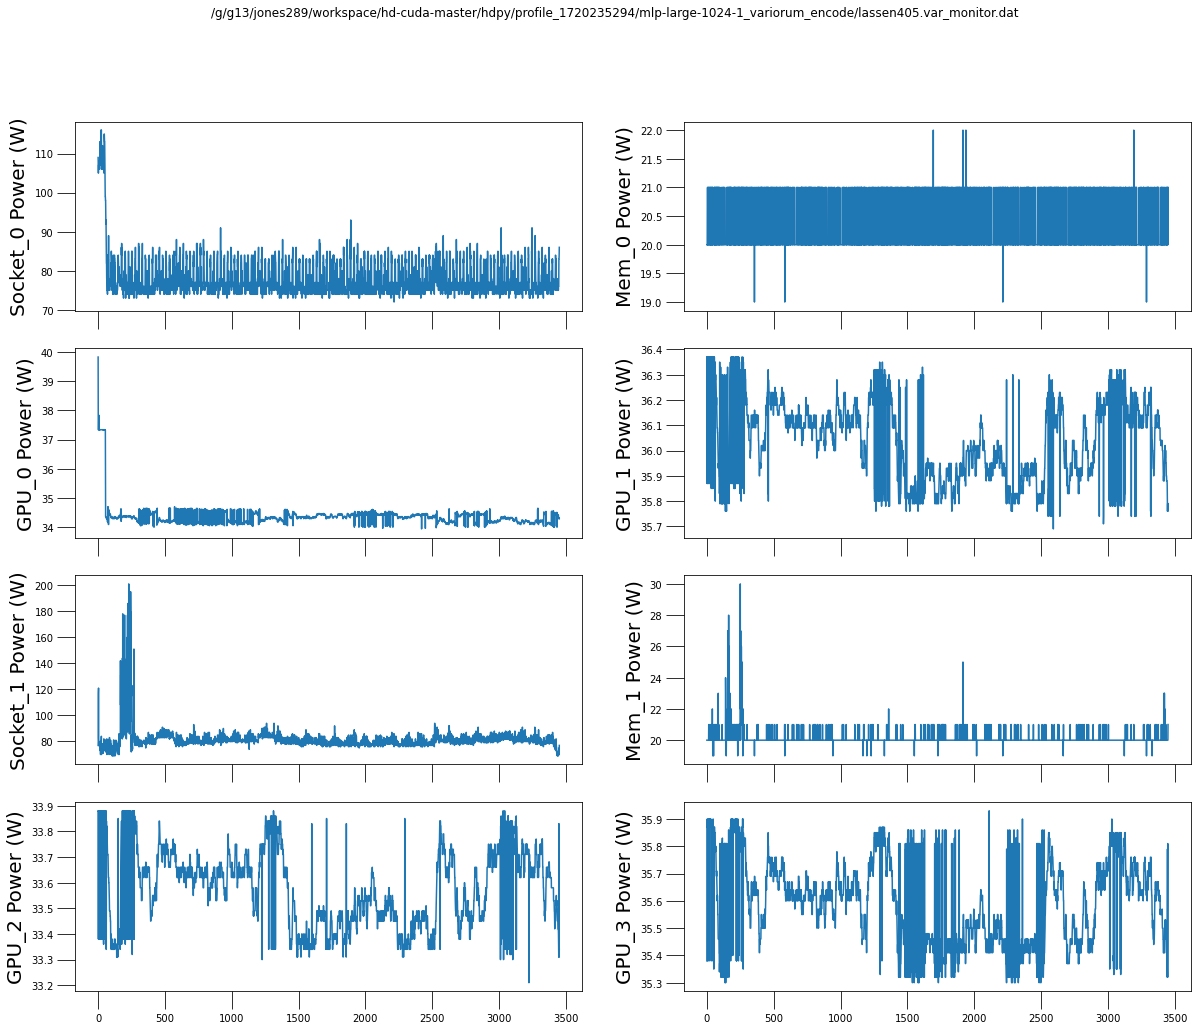

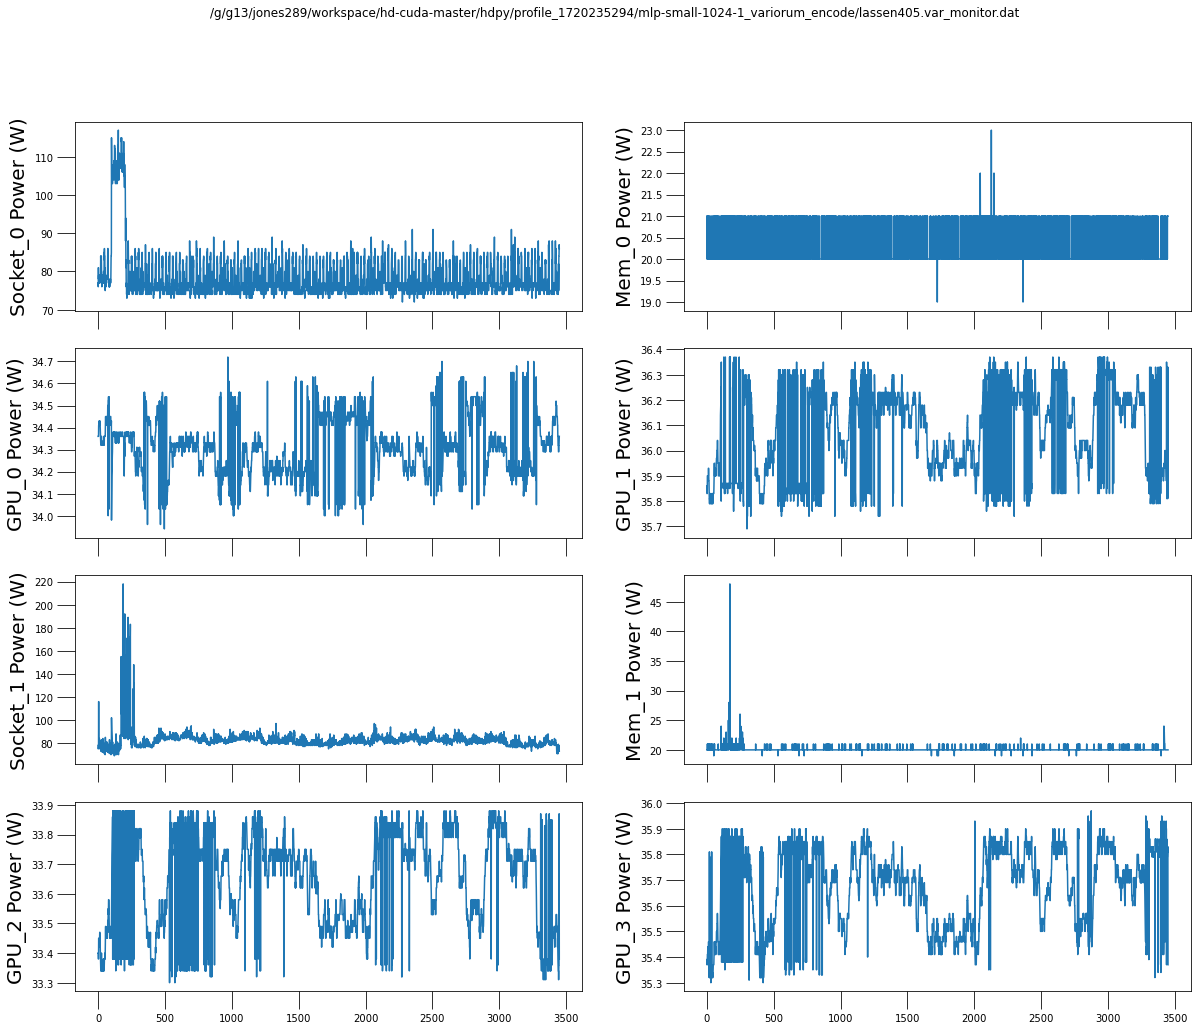

In [3]:

result_dir = "profile_1720235294"
encode_path_list = list(Path(f"/g/g13/jones289/workspace/hd-cuda-master/hdpy/{result_dir}").glob("*_variorum_encode/*.dat"))
test_path_list = list(Path(f"/g/g13/jones289/workspace/hd-cuda-master/hdpy/{result_dir}").glob("*_variorum_test/*-trunc-sum.dat"))

encode_df = collect_energy_metrics(encode_path_list, power_mode=power_mode,verbose=True)
test_df = collect_energy_metrics(test_path_list, power_mode=power_mode, verbose=False)

energy_df = pd.concat([encode_df, test_df])
energy_df

In [4]:
# openhd_result_dir = "profile_openhd_1720052756"
# openhd_result_dir = "profile_openhd_1720059301"
# openhd_result_dir = "profile_openhd_1720061605"
# openhd_result_dir = "profile_openhd_1720061563"
# openhd_result_dir = "profile_openhd_1720234883"
openhd_result_dir = "profile_openhd_1720242681"
openhd_test_path_list = list(Path(f"/g/g13/jones289/workspace/hd-cuda-master/hdpy/{openhd_result_dir}").glob("hdbind-openhd_test/*-trunc-sum.dat"))
# print(openhd_test_path_list)

# openhd_test_df = pd.read_csv(openhd_test_path_list[0], index_col=0)
# openhd_test_df = openhd_test_df.loc['mean'].to_frame().transpose()
# print(convert_var_monitor_path_to_timing_path(openhd_test_path_list[0]))

openhd_test_df = collect_energy_metrics(openhd_test_path_list, power_mode=power_mode)
openhd_test_df

using mean for power estimate.


,path,model,mode,cpu_power,gpu_power,mean_time_crit,std_time_crit,cpu_energy,gpu_energy
0,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-openhd,test,172.92,52.5441,6.406888e-08,8.782539e-09,0.000011,0.000003


In [5]:
full_energy_df = pd.concat([energy_df, openhd_test_df], axis=0)
# full_energy_df['path'].to_list()
full_energy_df

,path,model,mode,cpu_power,gpu_power,mean_time_crit,std_time_crit,cpu_energy,gpu_energy
0,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-directecfp-1k-1,encode,158.299851,34.422957,3.622643e-04,8.163907e-08,0.057346,0.000000
1,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-molformer-decfp-combo-1k,encode,157.818036,47.704247,5.207949e-04,1.761928e-07,0.082191,0.024844
2,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-rp-molformer-1k,encode,154.015957,43.747952,1.516202e-07,7.264579e-10,0.000023,0.000007
3,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,mlp-large-1024-1,encode,159.234715,34.368890,3.636456e-04,7.313384e-08,0.057905,0.012498
4,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,mlp-small-1024-1,encode,161.075094,34.313010,3.636272e-04,4.252577e-08,0.058571,0.012477
0,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-directecfp-1k-1,test,158.289948,49.298218,1.222425e-07,1.620050e-08,0.000019,0.000006
1,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-molformer-decfp-combo-1k,test,158.032787,49.725410,1.120625e-07,2.035309e-08,0.000018,0.000006
2,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-rp-molformer-1k,test,157.740541,50.017730,9.921392e-08,7.009256e-09,0.000016,0.000005
3,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,mlp-large-1024-1,test,158.027933,62.386369,1.471285e-07,7.048933e-09,0.000023,0.000009
4,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,mlp-small-1024-1,test,159.659341,57.034451,4.025928e-08,5.996733e-09,0.000006,0.000002


In [6]:
col_list = ["1", "10", "100", "1000", "10000", "100000"]

def screen_cost(df):

    # molformer_llm_energy = 1.63E-01
    # molformer_llm_energy = 159.2987
    # molformer_llm_energy = 0.6284586992934288
    molformer_llm_energy = 0.3887505577486362
    screen_dict = {"Model": [], "Device":[],	"Encode (J/mol)": [], "Test (J/mol)": []}
    for col_val in col_list:
        screen_dict.update({col_val: []})

    for model, model_df in df.groupby("model"):
        if "openhd" in model:
            pass
        else:
            print(model)
            encode_gpu_energy = model_df[model_df["mode"] == "encode"]["gpu_energy"].values.flatten()[0]
            encode_cpu_energy = model_df[model_df["mode"] == "encode"]["cpu_energy"].values.flatten()[0]
            # encode_cpu_energy = 0
            encode_energy = encode_gpu_energy + encode_cpu_energy

            print(model)
            test_gpu_energy = model_df[model_df["mode"] == "test"]["gpu_energy"].values.flatten()[0]
            test_cpu_energy = model_df[model_df["mode"] == "test"]["cpu_energy"].values.flatten()[0]
            test_cpu_energy = 0
            test_energy = test_gpu_energy + test_cpu_energy

            # print(model, encode_energy, test_energy)

            screen_dict["Model"].append(model)
            screen_dict["Device"].append("GPU")
            

            if "molformer" in model:
                encode_energy += molformer_llm_energy

            screen_dict["Encode (J/mol)"].append(encode_energy)
            screen_dict["Test (J/mol)"].append(test_energy)

            for i in col_list:

                screen_cost = encode_energy + (float(i) * test_energy)
                screen_dict[i].append(screen_cost)
    
    # add FPGA numbers

    hdb_df = df[df["model"].apply(lambda x: "mlp" not in x and "openhd" not in x)]

    # fpga_test_energy=1.06426E-05
    # fpga_test_energy=0.00000003110961914 # this was a time...
    fpga_test_energy=0.0000007497418213

    for model, model_df in hdb_df.groupby(["model"]):
        # print(model, model_df)

        screen_dict["Model"].append(model)
        screen_dict["Device"].append("FPGA")

        encode_gpu_energy = model_df[model_df["mode"] == "encode"]["gpu_energy"].values.flatten()[0]
        encode_cpu_energy = model_df[model_df["mode"] == "encode"]["cpu_energy"].values.flatten()[0]
        # encode_cpu_energy = 0
        encode_energy = encode_gpu_energy + encode_cpu_energy


        test_cpu_energy = model_df[model_df["mode"] == "test"]["cpu_energy"].values.flatten()[0]
        test_cpu_energy = 0
        test_energy = test_cpu_energy + fpga_test_energy

        if "molformer" in model:
            print("adding LLM encode energy")
            encode_energy += molformer_llm_energy # this is the value of the per/mol energy cost I got from molformer on pascal

        screen_dict["Encode (J/mol)"].append(encode_energy)
        screen_dict["Test (J/mol)"].append(test_energy)

        for i in col_list:

            screen_cost = encode_energy + (float(i) * (test_energy))
            screen_dict[i].append(screen_cost)



    # add openhd numbers

    openhd_model_df = df[df["model"] == "hdbind-openhd"]
    openhd_test_energy = openhd_model_df[openhd_model_df["mode"] == "test"]["gpu_energy"].values.flatten()[0] 

    for model, model_df in df.groupby(["model"]):
        if "mlp" in model:
            pass
        elif "openhd" in model:
            pass
        else:
            print(f"add encoding to {model}")

            screen_dict["Model"].append(f"{model}-openhd")
            screen_dict["Device"].append("GPU")

            encode_gpu_energy = model_df[model_df["mode"] == "encode"]["gpu_energy"].values.flatten()[0]
            encode_cpu_energy = model_df[model_df["mode"] == "encode"]["cpu_energy"].values.flatten()[0]
            # encode_cpu_energy = 0
            encode_energy = encode_gpu_energy + encode_cpu_energy


            # test_cpu_energy = model_df[model_df["mode"] == "test"]["cpu_energy"].values.flatten()[0]
            # test_cpu_energy = 0
            # test_energy = test_cpu_energy + fpga_test_energy

            if "molformer" in model:
                print("adding LLM encode energy")
                encode_energy += molformer_llm_energy # this is the value of the per/mol energy cost I got from molformer on pascal

            screen_dict["Encode (J/mol)"].append(encode_energy)
            screen_dict["Test (J/mol)"].append(openhd_test_energy)

            for i in col_list:

                screen_cost = encode_energy + (float(i) * (openhd_test_energy))
                screen_dict[i].append(screen_cost) 



    screen_df = pd.DataFrame(screen_dict)

    return screen_df 


screen_df = screen_cost(df=full_energy_df)
screen_df

hdbind-directecfp-1k-1
hdbind-directecfp-1k-1
hdbind-molformer-decfp-combo-1k
hdbind-molformer-decfp-combo-1k
hdbind-rp-molformer-1k
hdbind-rp-molformer-1k
mlp-large-1024-1
mlp-large-1024-1
mlp-small-1024-1
mlp-small-1024-1
adding LLM encode energy
adding LLM encode energy
add encoding to hdbind-directecfp-1k-1
add encoding to hdbind-molformer-decfp-combo-1k
adding LLM encode energy
add encoding to hdbind-rp-molformer-1k
adding LLM encode energy


,Model,Device,Encode (J/mol),Test (J/mol),1,10,100,1000,10000,100000
0,hdbind-directecfp-1k-1,GPU,0.057346,6.026339e-06,0.057352,0.057407,0.057949,0.063373,0.117610,0.659980
1,hdbind-molformer-decfp-combo-1k,GPU,0.495786,5.572354e-06,0.495791,0.495841,0.496343,0.501358,0.551509,1.053021
2,hdbind-rp-molformer-1k,GPU,0.388781,4.962455e-06,0.388786,0.388830,0.389277,0.393743,0.438405,0.885026
3,mlp-large-1024-1,GPU,0.070403,9.178813e-06,0.070412,0.070495,0.071321,0.079582,0.162191,0.988284
4,mlp-small-1024-1,GPU,0.071048,2.296166e-06,0.071051,0.071071,0.071278,0.073345,0.094010,0.300665
5,hdbind-directecfp-1k-1,FPGA,0.057346,7.497418e-07,0.057347,0.057354,0.057421,0.058096,0.064844,0.132321
6,hdbind-molformer-decfp-combo-1k,FPGA,0.495786,7.497418e-07,0.495786,0.495793,0.495860,0.496535,0.503283,0.570760
7,hdbind-rp-molformer-1k,FPGA,0.388781,7.497418e-07,0.388781,0.388788,0.388856,0.389530,0.396278,0.463755
8,hdbind-directecfp-1k-1-openhd,GPU,0.057346,3.366441e-06,0.057350,0.057380,0.057683,0.060713,0.091011,0.393991
9,hdbind-molformer-decfp-combo-1k-openhd,GPU,0.495786,3.366441e-06,0.495789,0.495819,0.496122,0.499152,0.529450,0.832430


HDB-DECFP (FPGA)
HDB-DECFP (GPU)
HDB-DECFP (GPU)
HDB-Combo (FPGA)
HDB-Combo (GPU)
HDB-Combo (GPU)
HDB-MoLFormer (FPGA)
HDB-MoLFormer (GPU)
HDB-MoLFormer (GPU)
MLP-large (GPU)
MLP-small (GPU)


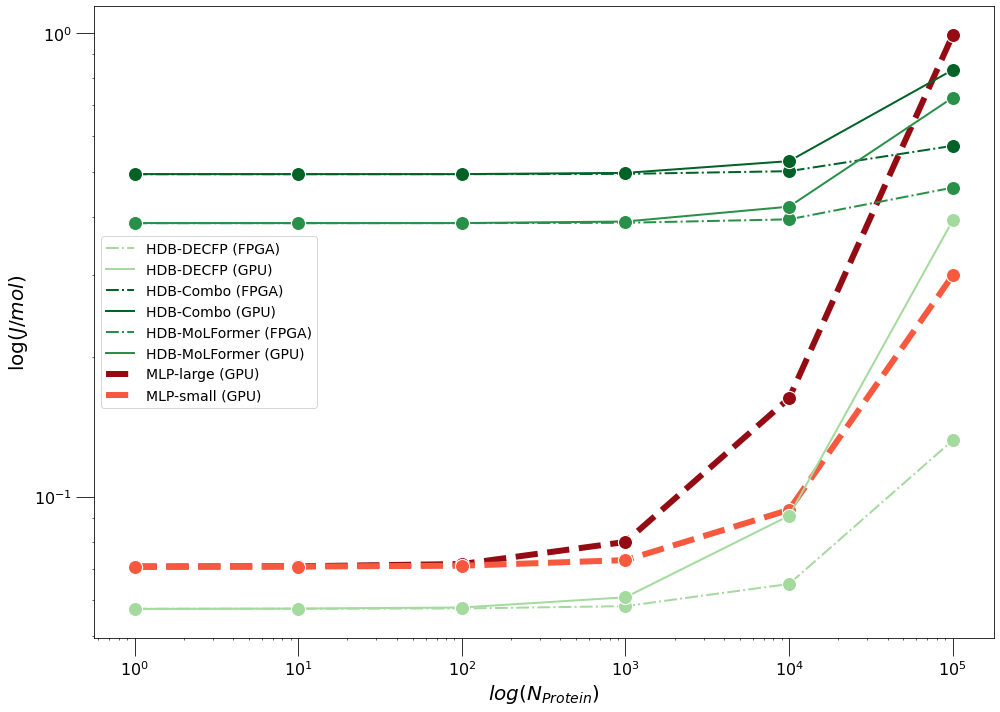

In [12]:
green_color_pal = sns.color_palette("Greens", 10)
blue_color_pal = sns.color_palette("Blues", 10)
red_color_pal = sns.color_palette("Reds", 10)
purple_color_pal = sns.color_palette("Purples", 10)
rocket_color_pal = sns.color_palette("rocket", 10)


# plot_dict = {
            # "mlp-small-1024-1": ("MLP-small", red_color_pal[5]),
            # "mlp-large-1024-1": ("MLP-large", red_color_pal[9]),
            # "hdbind-molformer-decfp-combo-1k": ("HDB-Combo", green_color_pal[9]),
            # "hdbind-directecfp-1k-1": ("HDB-DECFP", green_color_pal[3]),
            # "hdbind-rp-molformer-1k": ("HDB-MoLFormer", green_color_pal[7])
    # }
plot_dict = {
            "mlp-small-1024-1": ("MLP-small", red_color_pal[5]),
            "mlp-large-1024-1": ("MLP-large", red_color_pal[9]),
            "hdbind-directecfp-1k-1-openhd": ("HDB-DECFP", green_color_pal[3]),
            "hdbind-rp-molformer-1k-openhd": ("HDB-MoLFormer", green_color_pal[7]),
            "hdbind-molformer-decfp-combo-1k": ("HDB-Combo", green_color_pal[9]),
            "hdbind-directecfp-1k-1": ("HDB-DECFP", green_color_pal[3]),
            "hdbind-rp-molformer-1k": ("HDB-MoLFormer", green_color_pal[7]),
            "hdbind-molformer-decfp-combo-1k-openhd": ("HDB-Combo", green_color_pal[9]),
            "combo-1k-openhd": ("HDB-Combo", green_color_pal[9]),
    }



def main(df):



    # f, ax = plt.subplots(1,1, figsize=(16,10))
    f, ax = plt.subplots(1,1, figsize=(14,10))


    zorder = 1
    for idx, ((model, device), model_df) in enumerate(df.groupby(["Model", "Device"])):

        if model in plot_dict.keys():
            x = [int(x) for x in col_list]
            y = model_df[col_list].values.reshape(-1)
            
            color = plot_dict[model][1]

            model_title = f"{plot_dict[model][0]} ({device})"

            print(model_title)


            linestyle = "-"
            label=model_title
            # linewidth=4
            linewidth=2
            s=200

            # if "molformer" in model.lower() and not "combo" in model.lower():
                # continue
            # elif "mlp" not in model.lower():
            if "mlp" not in model.lower():
                zorder = idx

                if device == "FPGA":
                    linestyle = "-."
                    # continue
                elif "openhd" in model:
                    linestyle = "-"
                elif device == "GPU":
                    s=100
                    # pass
                    continue
            else:
                linewidth = 6
                zorder = 0
                linestyle = "--"


            sns.lineplot(x=x, y=y, label=label, ax=ax, markers="x", color=color, linestyle=linestyle, linewidth=linewidth,
                                zorder=zorder)
            sns.scatterplot(x=x, y=y, ax=ax, color=color, s=s, zorder=zorder)


    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel("$\log(J/{mol})$")
    ax.set_xlabel("$log$($N_{Protein})$")

    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.savefig("hdbind_energy.png", dpi=450)


# screen_path = Path("energy_usage_vs_targets.csv")
# if not screen_path.exists():
# screen_df.to_csv(screen_path)
# else:
# screen_df = pd.read_csv(screen_path, index_col=0)
screen_path = Path("final_screen_cost.csv")
screen_df = pd.read_csv(screen_path, sep="\t")
screen_df
main(screen_df)

In [14]:
encode_col_str = 'Encode (J/mol)'
test_col_str = 'Test (J/mol)'
screen_df[encode_col_str] = screen_df[encode_col_str].astype(float)
screen_df[test_col_str] = screen_df[test_col_str].astype(float)

round_df = screen_df.round({encode_col_str: 3, test_col_str: 12, '1': 3, '10': 3, '100': 3, '1000': 3, '10000': 3, '100000': 3})
mlp_large_test_energy = round_df[round_df["Model"] == "mlp-large-1024-1"][test_col_str]
mlp_small_test_energy = round_df[round_df["Model"] == "mlp-small-1024-1"][test_col_str]
round_df["mlp-large_test_improvement"] = round_df.apply(lambda x:  mlp_large_test_energy / x[test_col_str], axis=1)
round_df["mlp-small_test_improvement"] = round_df.apply(lambda x:  mlp_small_test_energy / x[test_col_str], axis=1)
round_df
round_df[round_df["Model"] == "mlp-large-1024-1"]["Test (J/mol)"]
print(round_df)
print(round_df['Encode (J/mol)'])
round_df['Test (J/mol)']
round_df.to_latex("hdbind_latex_energy_costs.tex", index=False)

                                     Model Device  Encode (J/mol)  \
0                   hdbind-directecfp-1k-1    GPU           0.057   
1                   hdbind-rp-molformer-1k    GPU           0.389   
2          hdbind-molformer-decfp-combo-1k    GPU           0.496   
3            hdbind-directecfp-1k-1-openhd    GPU           0.057   
4            hdbind-rp-molformer-1k-openhd    GPU           0.389   
5   hdbind-molformer-decfp-combo-1k-openhd    GPU           0.496   
6                         mlp-small-1024-1    GPU           0.071   
7                         mlp-large-1024-1    GPU           0.071   
8                   hdbind-directecfp-1k-1   FPGA           0.057   
9                   hdbind-rp-molformer-1k   FPGA           0.389   
10         hdbind-molformer-decfp-combo-1k   FPGA           0.496   

    Test (J/mol)      1     10    100   1000  10000  100000  \
0   5.520000e-06  0.057  0.057  0.058  0.063  0.113   0.609   
1   5.520000e-06  0.389  0.389  0.389  0.394 

/var/tmp/jones289/ipykernel_418056/815290533.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  round_df.to_latex("hdbind_latex_energy_costs.tex", index=False)


In [15]:
round_df

,Model,Device,Encode (J/mol),Test (J/mol),1,10,100,1000,10000,100000,mlp-large_test_improvement,mlp-small_test_improvement
0,hdbind-directecfp-1k-1,GPU,0.057,5.520000e-06,0.057,0.057,0.058,0.063,0.113,0.609,1.663043,0.416667
1,hdbind-rp-molformer-1k,GPU,0.389,5.520000e-06,0.389,0.389,0.389,0.394,0.444,0.941,1.663043,0.416667
2,hdbind-molformer-decfp-combo-1k,GPU,0.496,5.520000e-06,0.496,0.496,0.496,0.501,0.551,1.050,1.663043,0.416667
3,hdbind-directecfp-1k-1-openhd,GPU,0.057,3.370000e-06,0.057,0.057,0.058,0.061,0.091,0.394,2.724036,0.682493
4,hdbind-rp-molformer-1k-openhd,GPU,0.389,3.370000e-06,0.389,0.389,0.389,0.392,0.422,0.725,2.724036,0.682493
5,hdbind-molformer-decfp-combo-1k-openhd,GPU,0.496,3.370000e-06,0.496,0.496,0.496,0.499,0.529,0.832,2.724036,0.682493
6,mlp-small-1024-1,GPU,0.071,2.300000e-06,0.071,0.071,0.071,0.073,0.094,0.300,3.991304,1.000000
7,mlp-large-1024-1,GPU,0.071,9.180000e-06,0.071,0.071,0.072,0.080,0.163,0.989,1.000000,0.250545
8,hdbind-directecfp-1k-1,FPGA,0.057,7.497420e-07,0.057,0.057,0.057,0.058,0.065,0.132,12.244212,3.067722
9,hdbind-rp-molformer-1k,FPGA,0.389,7.497420e-07,0.389,0.389,0.389,0.390,0.396,0.464,12.244212,3.067722
